In [1]:
# file = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [1]:
from fastai.vision.all import *
from fastai.optimizer import ranger

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
path = Path('/home/norbert/Documents/repos/engineerka/data/road')

path_im = path/'unlabeled'
path_lbl = path/'labeled'

In [3]:
lbl_names = get_image_files(path_lbl)
fnames = get_image_files(path_im)

In [4]:
fnames

(#67) [Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_300.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_52.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_405.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_16.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_12.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_294.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_61.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_42.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_22.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_375.png')...]

In [5]:
lbl_names[5]

Path('/home/norbert/Documents/repos/engineerka/data/road/labeled/road_294.png')

In [6]:
fn = 'road_32.png'

In [7]:
im = PILImage.create(f'{path_im}/{fn}')
msk = PILMask.create(f'{path_lbl}/road_32.png')

In [8]:
len(np.unique(msk))

2

In [9]:
np.unique(msk)

array([  0, 255], dtype=uint8)

In [10]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [11]:
p2c = n_codes(lbl_names)

In [12]:
p2c

{0: 0, 1: 255}

In [13]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = path_lbl/f'{fn.stem}{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [14]:
codes = ['lane', 'not lane']

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['not lane']
name2id

{'lane': 0, 'not lane': 1}

In [15]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [16]:
opt = ranger

In [17]:
get_y = lambda o: get_msk(o, p2c)

In [18]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(448),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])


# camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                #    get_items=get_image_files,
                #    splitter=FileSplitter(path/'valid.txt'),
                #    get_y=get_msk,
                #    batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [19]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [20]:
path_im

Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled')

In [21]:
dls = binary.dataloaders(path_im, bs=4)

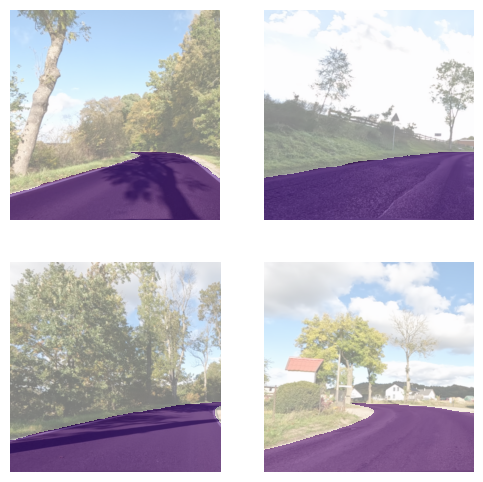

In [22]:
dls.show_batch(cmap='Purples', vmin=0, vmax=1)

In [23]:
# learn = unet_learner(dls, resnet34)
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)


/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# fnames2 = get_files(path/'test', extensions=".png")
# dl = learn.dls.test_dl(fnames2)

SuggestedLRs(valley=5.248074739938602e-05)

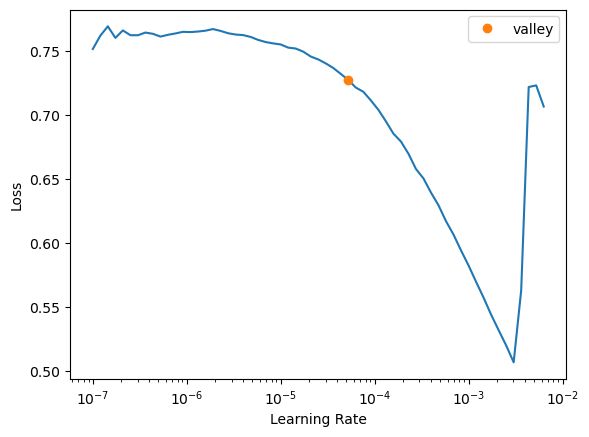

In [25]:
learn.lr_find()

In [26]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.538750,0.412093,0.998555,00:08
1,0.319834,0.157352,0.922140,00:07
2,0.215950,0.031709,0.988360,00:07
3,0.146879,0.027104,0.996898,00:08
4,0.108680,0.034879,0.988238,00:08
5,0.084873,0.020078,0.996170,00:08
6,0.066579,0.022483,0.995906,00:07
7,0.054281,0.018182,0.994786,00:08


In [27]:
lr = 1e-3
lr

0.001

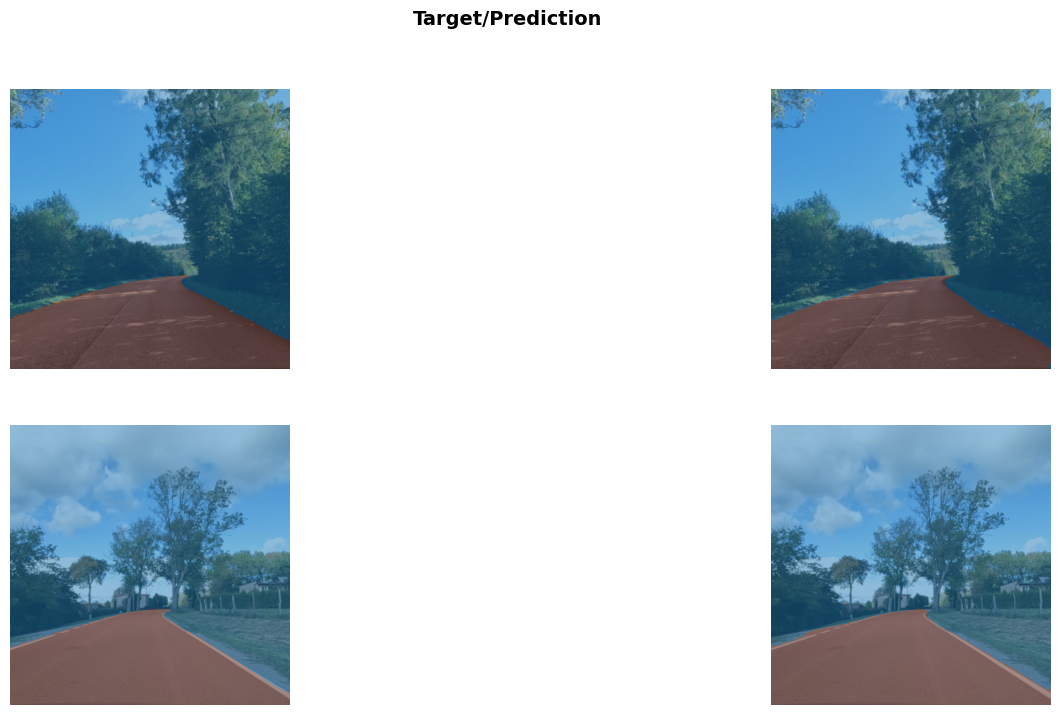

In [28]:
learn.show_results(max_n=2, figsize=(18,8))
# learn.summary()
# learn.lr_find()
# lr = 1e-3
# learn.fit_flat_cos(10, slice(lr))
# learn.save('stage-1')
# learn.load('stage-1');
# learn.show_results(max_n=4, figsize=(12,6))


In [29]:
# learn.load('stage-1');

In [30]:
dl = learn.dls.test_dl([Path('/home/norbert/Documents/repos/engineerka/data/unlabeled_test/street_3_204.png')])

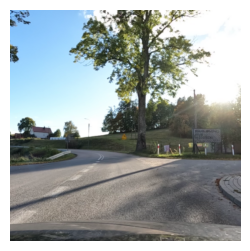

In [31]:
# dl = learn.dls.test_dl(fnames[:5])



dl.show_batch()

In [32]:
preds = learn.get_preds(dl=dl)

In [33]:
preds[0].shape

torch.Size([1, 2, 448, 448])

In [34]:
len(codes)

2

In [35]:
pred_1 = preds[0][0]

In [36]:
pred_1.shape

torch.Size([2, 448, 448])

In [37]:
pred_arx = pred_1.argmax(dim=0)

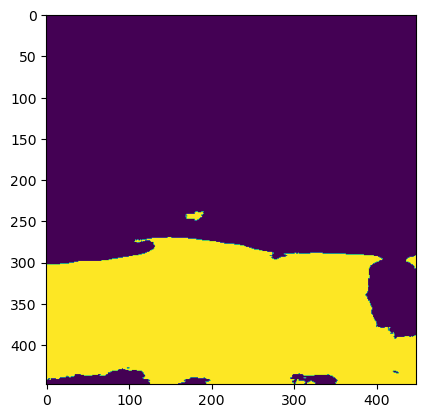

In [38]:
plt.imshow(pred_arx)

In [39]:
pred_arx = pred_arx.numpy()

In [40]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [41]:
im = Image.fromarray(rescaled)

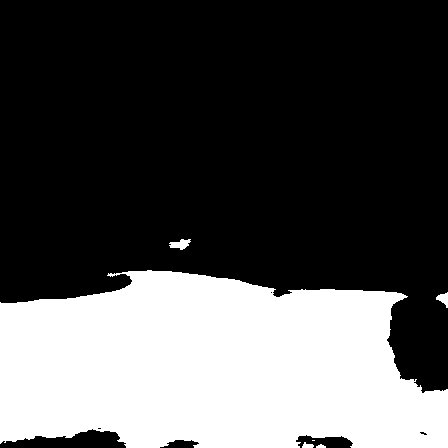

In [42]:
im

In [43]:
im.save('test.png')

In [44]:
import numpy as np
import cv2 as cv
import PIL

In [45]:

cap = cv.VideoCapture('/home/norbert/Documents/datasets/engineerka/100GOPRO/keblowo_4.MP4')


if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    new_data = PIL.Image.fromarray(frame * 255)
    
    if new_data.mode != 'RGB':
        new_data = new_data.convert('RGB')
    
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Display the resulting frame
    cv.imshow('frame', gray)
    if cv.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to target thread (0x55bdc432b720)

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to target thread (0x55bdc432b720)

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to target thread (0x55bdc432b720)

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to target thread (0x55bdc432b720)

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to target thread (0x55bdc432b720)

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to target thread (0x55bdc432b720)

QObject::moveToThread: Current thread (0x55bdc432b720) is not the object's thread (0x55be4cc7f960).
Cannot move to tar

In [46]:
type(frame)

numpy.ndarray

In [47]:
frame.shape

(1080, 1920, 3)

In [49]:
new_data.shape

(1080, 1920)

In [57]:
newer_data = new_data.resize((448, 448))

In [59]:
import torchvision.transforms as transforms

transform = transforms.ToTensor()
tensor = transform(newer_data)
tensor.shape

torch.Size([3, 448, 448])

In [60]:
dl = learn.dls.test_dl(tensor)

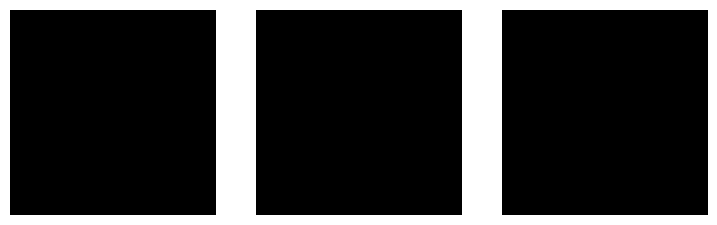

In [61]:
dl.show_batch()

In [62]:
preds = learn.get_preds(dl=dl)

In [63]:
preds[0].shape

torch.Size([3, 2, 448, 448])

In [64]:
preds[0][0].shape

torch.Size([2, 448, 448])

In [65]:
preds[0][0]

TensorBase([[[9.3426e-01, 9.7112e-01, 9.9735e-01,  ..., 9.9970e-01,
              9.9724e-01, 9.8941e-01],
             [9.4978e-01, 9.9183e-01, 9.9916e-01,  ..., 9.9992e-01,
              9.9921e-01, 9.9687e-01],
             [9.9658e-01, 9.9977e-01, 9.9999e-01,  ..., 1.0000e+00,
              9.9987e-01, 9.9920e-01],
             ...,
             [9.4905e-01, 9.8534e-01, 9.9363e-01,  ..., 9.7284e-01,
              9.4692e-01, 9.2398e-01],
             [8.5932e-01, 9.2748e-01, 9.6973e-01,  ..., 9.3899e-01,
              9.2850e-01, 9.0031e-01],
             [8.0594e-01, 8.7057e-01, 9.4684e-01,  ..., 8.9533e-01,
              8.7686e-01, 8.2683e-01]],

            [[6.5739e-02, 2.8884e-02, 2.6496e-03,  ..., 3.0462e-04,
              2.7555e-03, 1.0593e-02],
             [5.0225e-02, 8.1654e-03, 8.3894e-04,  ..., 7.6593e-05,
              7.8933e-04, 3.1285e-03],
             [3.4154e-03, 2.3294e-04, 9.8338e-06,  ..., 1.5871e-06,
              1.2839e-04, 8.0379e-04],
             ...,

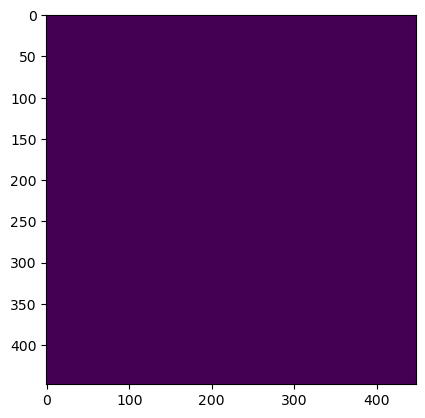

In [66]:
pred_arx = preds[0][0].argmax(dim=0)
plt.imshow(pred_arx)